In [1]:
import sys
sys.path

['/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/home/rpal/.local/lib/python3.10/site-packages',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/dlib-19.16.0-py3.10-linux-x86_64.egg',
 '/usr/lib/python3/dist-packages']

In [2]:
sys.path.append("../../quMCMC")  # Adjust the path as necessary #this is a bit strange isn't it?

In [3]:
import qumcmc

In [4]:
## import essential modules 
from qumcmc.basic_utils import *
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import classical_mcmc
from qumcmc.quantum_mcmc_routines import quantum_enhanced_mcmc # Manuel's code
from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics
from qumcmc.prob_dist import DiscreteProbabilityDistribution

### Case of BAS dataset. final plots

In [5]:
gridsize=3
bas= bas_dataset(grid_size=gridsize)
bas.dataset.sort()

     MODEL : ising model BAS 9X9 |  beta : 1.5
Num Most Probable States : 12
Entropy : 3.5849625001146053
---------------------------------------------


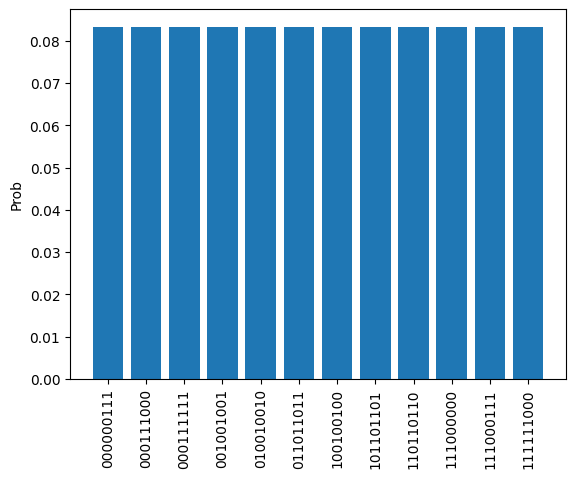

In [6]:
# consider only the bars dataset and create the weight matrix for them and create the ising model
wt = hebbing_learning(bas.bas_dict["bars"]+ bas.bas_dict["stripes"])
n_spins=gridsize*gridsize
shape_of_J=(n_spins,n_spins)
J=-1*wt
h=np.zeros(n_spins)
model=IsingEnergyFunction(J,h,name=f'ising model BAS {n_spins}X{n_spins}')

beta=1.5
## run exact sampling over all possible configurations 
exact_sampled_model = Exact_Sampling(model, beta)

## get distribution from the model
bpd= DiscreteProbabilityDistribution(exact_sampled_model.boltzmann_pd)
exact_sampled_model.sampling_summary()


In [7]:
# bas.bas_dict["stripes"]

In [7]:
from typing import Union
from qumcmc.basic_utils import plot_with_error_band

import matplotlib.colors as mcolors


def plot_proposal_and_acceptance_prob(input,list_of_list_running_kl,labels,
                                    gridsize=3,steps=50000, 
                                    std_dev_multiplicative_factor=0.5,
                                    dist: Union[str, list]=0):
    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    (ax1, ax2, ax3) = axes

    num_plots=len(input)
    ### hamming plot
    for i in range(0,num_plots):
        ax1.plot(np.arange(gridsize**2+1), [r["total"]/steps for r in input[i]["hamming"].values()],
                                                    marker="o", label=labels[i])
        #ax1.set_yscale("log")
        ax1.set_ylabel("Proposal Probability")
        ax1.set_xlabel("Hamming Distance")
    ax1.legend(fontsize=8)

    ### acceptance probability
    marker_formats = ['o', 's', '^', 'D', 'v']
    # list of colors
    colors = list(mcolors.TABLEAU_COLORS.keys())[:num_plots]
    for i in range(0, num_plots):
        ax2.stem(np.arange(gridsize**2+1)+dist[i], [r["accepted"]/r["total"] if r["total"] >0 
                                            else 0 for r in input[i]["hamming"].values() ], 
                                            label=labels[i],markerfmt=marker_formats[i],
                                            linefmt=f'C{i}-') ### remove.bar
        
        # ax2.bar(np.arange(gridsize**2+1)+dist[i], [r["accepted"]/r["total"] if r["total"] >0 
        #                                     else 0 for r in input[i]["hamming"].values() ], 
        #                                     label=labels[i]) ### remove.bar
    # plt.yscale("log")
    ax2.set_ylabel("Aceptance Probability")
    ax2.set_xlabel("Hamming Distance")
    ax2.set_xticks([0,1,2,3,4,5,6,7,8,9])
    ax2.legend(fontsize=7.5)

    ### KL plot
    #xval=np.arange(0,len(list_of_list_running_kl[0][0]))
    #print("len xval is:",len(xval))
    for i in range(0,num_plots):
        xval=np.arange(0,len(list_of_list_running_kl[i][0]))
        curve_mean_value= np.mean(list_of_list_running_kl[i],axis=0)
        standard_dev_band=np.std(list_of_list_running_kl[i],axis=0)
        ax3.plot(xval, curve_mean_value, "-", label=labels[i])
        ax3.fill_between(xval, 
                            curve_mean_value-standard_dev_band*std_dev_multiplicative_factor,
                            curve_mean_value+standard_dev_band*std_dev_multiplicative_factor,
                            alpha=0.5)
    ax3.set_yscale("log")
    ax3.set_ylabel("KL Divergence")
    ax3.set_xlabel("MCMC Iteration")
    ax3.legend(loc="upper right",fontsize=7.5)


In [9]:
### file to load
import os
import pickle

# Get the current working directory (PWD)
pwd = os.getcwd()

# Define the new folder name
new_folder_name = "results_with_new_code"

# Create the full path for the new folder
results_folder_location = os.path.join(pwd, new_folder_name)

results_folder_location

'd:\\Desktop\\QBM_project_cleaned\\quMCMC\\final_results_notebooks\\results_with_new_code'

In [10]:
# Load data from mcmc_wt1_bars_only.pkl
f = results_folder_location +  "\\BAS_new_code_final_plots_wt1.pkl"
with open(f, "rb") as file:
    mcmc_BAS_wt1 = pickle.load(file)

f = results_folder_location + "\\BAS_new_code_final_plots_wt1_75_bars_info_symm_25_gamma_std.pkl"
with open(f, "rb") as file:
    mcmc_BAS_wt1_bars_coh = pickle.load(file)

f = results_folder_location + "\\BAS_new_code_final_plots_wt1_75_stripes_info_symm_25_gamma_std.pkl"
with open(f, "rb") as file:
    mcmc_BAS_wt1_stripes_coh  = pickle.load(file)

f = results_folder_location + "\\BAS_new_code_final_plots_wt1_70_BAS_info_symm_30_gamma_std.pkl"
with open(f, "rb") as file:
    mcmc_BAS_generic_bas_coh = pickle.load(file)

f = results_folder_location + "\\BAS_new_code_final_plots_wt1_75_bars_info_symm_25_gamma_std_incoherent.pkl"
with open(f, "rb") as file:
    mcmc_BAS_wt1_bars_incoh = pickle.load(file)

f = results_folder_location + "\\BAS_new_code_final_plots_wt1_75_stripes_info_symm_25_gamma_std_incoherent.pkl"
with open(f,"rb") as file:
    mcmc_BAS_wt1_stripes_incoh = pickle.load(file)

# f = results_folder_location + "\\BAS_new_code_final_plots_wt1_70_BAS_info_symm_30_gamma_std_incoherent.pkl"
# with open(f, "rb") as file:
#     mcmc_BAS_generic_bas_incoh = pickle.load(file)

In [11]:
mcmc_1=mcmc_BAS_wt1[2]
wt_1_bas_processing=get_trajectory_statistics(mcmc_chain=mcmc_1,
                                            model=exact_sampled_model
                                            )

mcmc_2=mcmc_BAS_wt1_bars_coh[3]
custom_mixers_bars_coh = get_trajectory_statistics(mcmc_chain=mcmc_2,
                                            model=exact_sampled_model)

mcmc_3=mcmc_BAS_generic_bas_coh[4]
custom_mixers_bas_coh = get_trajectory_statistics(mcmc_chain=mcmc_3,
                                            model=exact_sampled_model)

mcmc_std = mcmc_BAS_wt1_bars_incoh[0]
custom_mixers_bars_incoh = get_trajectory_statistics(mcmc_chain=mcmc_std,
                                            model=exact_sampled_model)

# mcmc_std_just_bars =mcmc_BAS_generic_bas_incoh [0]
# custom_mixers_bas_incoh= get_trajectory_statistics(mcmc_chain=mcmc_std_just_bars,
#                                             model=exact_sampled_model)

# Add processing for stripes coherent case
mcmc_stripes_coh = mcmc_BAS_wt1_stripes_coh[3]
custom_mixers_stripes_coh = get_trajectory_statistics(mcmc_chain=mcmc_stripes_coh, model=exact_sampled_model)

# Add processing for stripes incoherent case
mcmc_stripes_incoh = mcmc_BAS_wt1_stripes_incoh[0]
custom_mixers_stripes_incoh = get_trajectory_statistics(mcmc_chain=mcmc_stripes_incoh, model=exact_sampled_model)

list_for_plotting=[wt_1_bas_processing,custom_mixers_bars_coh,custom_mixers_bas_coh,custom_mixers_bars_incoh]
                #,custom_mixers_bas_incoh]### I have not added stripes case for now: custom_mixers_stripes_coh ,custom_mixers_stripes_incoh

In [12]:
### code to get list of running kl divergences
def list_of_running_kl(list_of_mcmc_chains, bpd):
    list_kl=[]
    for i in tqdm(range(0,len(list_of_mcmc_chains))):
        kl=calculate_running_kl_divergence(bpd,
                                            mcmc_chain=list_of_mcmc_chains[i],
                                            skip_steps=1)
        list_kl.append(kl)
    
    return list_kl

In [13]:
list_kl_wt1 = list_of_running_kl(mcmc_BAS_wt1, bpd=bpd)
list_kl_wt1_bars_coh = list_of_running_kl(mcmc_BAS_wt1_bars_coh, bpd=bpd)
list_kl_wt1_stripes_coh = list_of_running_kl(mcmc_BAS_wt1_stripes_coh, bpd=bpd)
list_kl_generic_bas_coh = list_of_running_kl(mcmc_BAS_generic_bas_coh, bpd=bpd)
list_kl_wt1_bars_incoh = list_of_running_kl(mcmc_BAS_wt1_bars_incoh, bpd=bpd)
list_kl_wt1_stripes_incoh = list_of_running_kl(mcmc_BAS_wt1_stripes_incoh, bpd=bpd)
#list_kl_generic_bas_incoh = list_of_running_kl(mcmc_BAS_generic_bas_incoh, bpd=bpd)

100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


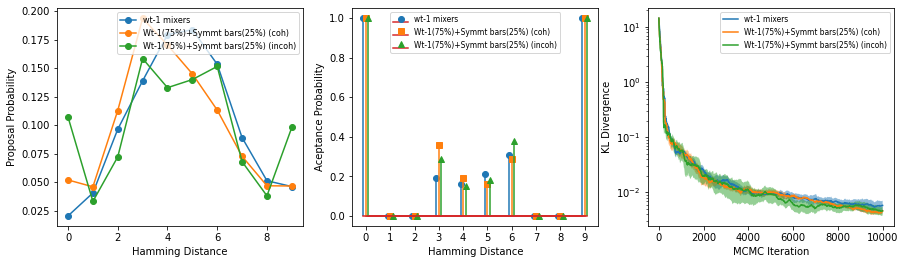

In [21]:
### generating all the plots
plot_proposal_and_acceptance_prob(input=[wt_1_bas_processing,custom_mixers_bars_coh,custom_mixers_bars_incoh],
                                list_of_list_running_kl=[list_kl_wt1, list_kl_wt1_bars_coh,list_kl_wt1_bars_incoh]#, list_kl_generic_bas_coh,
                                                                #list_kl_wt1_bars_incoh],#, list_kl_generic_bas_incoh],
                                ,steps=10000,
                                labels=["wt-1 mixers", # 0.4,0.6: gamma range
                                        "Wt-1(75%)+Symmt bars(25%) (coh)",#0.9,0.95# gamma range
                                        #"Wt-1(70%)+BAS(30%) (coh)",# 0.9,0.95 #gamma range
                                        "Wt-1(75%)+Symmt bars(25%) (incoh)"],#0.9,0.95# gamma range
                                        #"Wt-1(70%)+BAS(30%) (incoh)"]# 0.9,0.95 #gamma range"],
                                dist=[-0.10,0,0.10])#[-0.20,-0.10,0.10,0.20])#[-0.20,-0.10,0.0,0.10,0.20]

In [17]:
### need to plot the running average

# from qumcmc.basic_utils import plot_with_error_band

# plot_with_error_band(xval=list(range(1,30000+2)),
#                         y_list_of_list=list_kl_wt1,
#                         label="Wt1-mixer")
# plt.yscale("log")

### checking the Bars dataset

     MODEL : ising model 9X9 bars only |  beta : 1.5
Num Most Probable States : 6
Entropy : 2.5849625007211547
---------------------------------------------


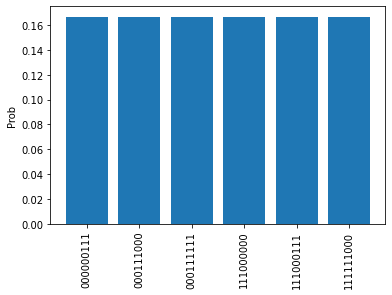

In [138]:
# consider only the bars dataset and create the weight matrix for them and create the ising model
wt = hebbing_learning(bas.bas_dict["bars"])
n_spins=gridsize*gridsize
shape_of_J=(n_spins,n_spins)
J=-1*wt
h=np.zeros(n_spins)
model=IsingEnergyFunction(J,h,name=f'ising model {n_spins}X{n_spins} bars only')

beta=1.5
## run exact sampling over all possible configurations 
exact_sampled_model = Exact_Sampling(model, beta)

## get distribution from the model
bpd= DiscreteProbabilityDistribution(exact_sampled_model.boltzmann_pd)
exact_sampled_model.sampling_summary()

In [139]:
# Load data from mcmc_wt1_bars_only.pkl
f = "Bars_final_plots_Wt1.pkl "
with open(f, "rb") as file:
    mcmc_bars_wt1= pickle.load(file)

f = "Bars_final_plots_symmetrix.pkl "
with open(f, "rb") as file:
    mcmc_bars_symmetric = pickle.load(file)

f = "Bars_final_plots_Wt3.pkl "
with open(f, "rb") as file:
    mcmc_bars_wt3 = pickle.load(file)

In [140]:
mcmc_1=mcmc_bars_wt1[2]
wt_1_bars_processing=get_trajectory_statistics(mcmc_chain=mcmc_1,
                                            model=exact_sampled_model
                                            )

mcmc_2=mcmc_bars_symmetric[2]
custom_mixers_bars_processing = get_trajectory_statistics(mcmc_chain=mcmc_2,
                                            model=exact_sampled_model)

mcmc_3=mcmc_bars_wt3[2]
custom_mixers_bars_processing2 = get_trajectory_statistics(mcmc_chain=mcmc_3,
                                            model=exact_sampled_model)

In [141]:
list_kl_wt1=list_of_running_kl(mcmc_bars_wt1, bpd=bpd)### these themselves are list of lists
list_kl_symmetric=list_of_running_kl(mcmc_bars_symmetric, bpd=bpd)
list_kl_wt3=list_of_running_kl(mcmc_bars_wt3, bpd=bpd)
list_of_list_kl=[list_kl_wt1, list_kl_symmetric, list_kl_wt3]

100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


len xval is: 30001


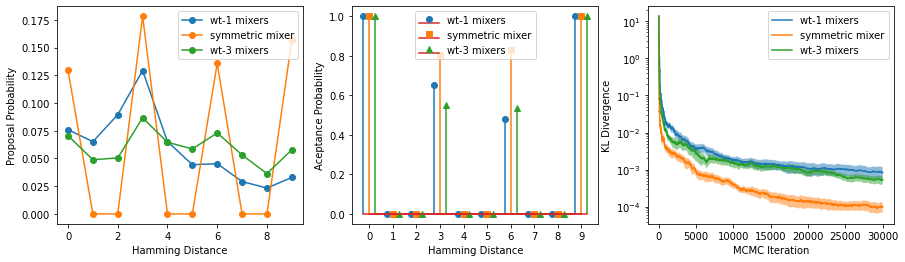

In [143]:
### generating all the plots
plot_proposal_and_acceptance_prob(input=[wt_1_bars_processing,custom_mixers_bars_processing,custom_mixers_bars_processing2],
                                    list_of_list_running_kl=list_of_list_kl,
                                    labels=["wt-1 mixers", "symmetric mixer","wt-3 mixers"],
                                    dist=[-0.25,0,0.25])

In [ ]:
### manuel bhaiya's code

# fig, axes = plt.subplots(1, 3, figsize=(15,4))
# (ax1, ax2, ax3) = axes

# ax1.plot(np.arange(gridsize**2+1), [r["total"]/steps for r in r["hamming"].values()], marker="o", label="With System H")
# ax1.plot(np.arange(gridsize**2+1), [r["total"]/steps for r in rm["hamming"].values()], marker="o", label="Mismatched H")
# ax1.plot(np.arange(gridsize**2+1), [r["total"]/steps for r in rz["hamming"].values()], marker="o", label="Without System H", color="grey")
# ax1.set_yscale("log")
# ax1.set_ylabel("Proposal Probability")
# ax1.set_xlabel("Hamming Distance")
# ax1.legend()

# ax2.bar(np.arange(gridsize**2+1)-0.8, [r["accepted"]/r["total"] if r["total"] >0 else 0 for r in hams.values() ], label="With System H")
# ax2.bar(np.arange(gridsize**2+1)-0.0, [r["accepted"]/r["total"] if r["total"] >0 else 0 for r in hams_miss.values() ], label="Mismatched H")
# ax2.bar(np.arange(gridsize**2+1)+0.8, [r["accepted"]/r["total"] if r["total"] >0 else 0 for r in hams_zero.values() ], label="Without System H", color="grey")
# # plt.yscale("log")
# ax2.set_ylabel("Aceptance Probability")
# ax2.set_xlabel("Hamming Distance")
# ax2.set_xticks([0, 3, 6, 9])
# ax2.legend()

# ax3.plot(r["kldiv"], label="With System H")
# ax3.plot(rm["kldiv"], label="Mismatched H")
# ax3.plot(rz["kldiv"], label="Without System H", color="grey")
# plt.yscale("log")
# ax3.set_ylabel("KL Divergence")
# ax3.set_xlabel("MCMC Iteration")
# ax3.legend(loc="upper right")

